# Feauture Selection

## Imports & Load Data

In [ ]:
# Import the required packages
import os
import sys
in_colab = 'google.colab' in sys.modules

In [ ]:
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/My Drive/Colab Notebooks/Data/"
else:
    BASE_DIR = "./Data/"

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp
import statsmodels.api as sm
import pickle

from sklearn import metrics
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

from xgboost.sklearn import XGBRegressor

from IPython.display import display
from time import time
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Cargar endpoint
infile = open(BASE_DIR+'21_ETL_Tabular.pkl','rb')
tabular_ft = pickle.load(infile)
infile.close()

In [5]:
filename = BASE_DIR+'221_Graph_Metrics.pkl'
infile = open(filename, 'rb')
gmetrics_ft = pickle.load(infile)
infile.close()

In [6]:
filename = BASE_DIR+'222_ETRD_ROUTES_ELEC.pkl'
infile = open(filename, 'rb')
path_ft = pickle.load(infile)
infile.close()

In [7]:
filename = BASE_DIR+'1_OUTFT_UNTRD_FIC.pkl'
infile = open(filename, 'rb')
DEPVAR = pickle.load(infile)
infile.close()

## Preparar Datos

In [8]:
def prepare_data(X, categoricas):
    
    X = pd.get_dummies(X.dropna(), columns=categoricas, dummy_na= True, drop_first= True)
#    X = pd.get_dummies(X, columns = categoricas)

    FIC = X.FIC
    bin = np.array(FIC.values)
    FIC_bin = pd.cut(bin, bins=4, labels=False)
 
    X = X.drop(['FIC'], axis=1)
    X = X.fillna(0)

    return X, FIC, FIC_bin

In [9]:
def backwardElimination(x, y, sl):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    x = np.delete(x, j, 1)
    regressor_OLS.summary()
    return x

In [10]:
def backwardEliminationRQ(x, y, SL):
    numVars = len(x[0])
    temp = np.zeros((x.shape)).astype(int)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = x[:, j]
                    x = np.delete(x, j, 1)
                    tmp_regressor = sm.OLS(y, x).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        x_rollback = np.hstack((x, temp[:,[0,j]]))
                        x_rollback = np.delete(x_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return x_rollback
                    else:
                        continue
    regressor_OLS.summary()
    return x

In [11]:
tabular_cols = tabular_ft.columns

In [12]:
gmetrics_cols = gmetrics_ft.columns

In [13]:
path_ft.drop(['ROUTE_SUB','SID_ROUTE_SUB'], axis=1, inplace=True)
path_cols = path_ft.columns

In [14]:
data = pd.merge(tabular_ft, gmetrics_ft, on = 'COD_ID')
data = pd.merge(data, path_ft, on = 'COD_ID')

In [15]:
data = pd.merge(data, DEPVAR.reset_index(), left_on='COD_ID', right_on='UNI_TR_D')

In [16]:
data.drop(['PAC_1','UNI_TR_D_x','UNI_TR_D_y','UNTRD_PCON_x','UNTRD_PCON_y','UNI_TR_S',
           'CTMT_x','CTMT_y','SUB_x','SUB_y','CONJ','DESCR','CTMT_PCON'], axis=1, inplace=True)

In [17]:
data.shape

(3540, 70)

In [18]:
data.set_index('COD_ID', drop=True, inplace=True)


In [19]:
data

,FAS_CON_P,FAS_CON_S,FAS_CON_T,TEN_LIN_SE,CAP_ELO,CAP_CHA,CONF,POSTO,POT_NOM,PER_FER,...,FCONV_R,I_MAX_MED_R,I_MAX_MIN_R,I_NOM_MED_R,I_NOM_MIN_R,REAC_SUB,RESI_SUB,Z_MOD_SUB,Z_ANG_SUB,FIC
COD_ID,,,,,,,,,,,,,,,,,,,,,
26879192,ABC,ABC,0,0.38,2H,12,RA,PT,45.00,0.47,...,0.47,365.00,130.00,365.00,130.00,2014.67,3303.26,3869.16,-31.38,1.00
26880293,ABC,ABC,0,0.38,5H,12,RA,PT,112.50,0.38,...,0.46,438.00,97.00,438.00,97.00,1400.15,4011.34,4248.68,-19.24,0.00
26880293,ABC,ABC,0,0.38,5H,12,RA,PT,112.50,0.38,...,0.46,438.00,97.00,438.00,97.00,1400.15,4011.34,4248.68,-19.24,0.00
26880295,ABC,ABC,0,0.38,3H,12,RA,PT,75.00,0.43,...,0.46,438.00,97.00,438.00,97.00,1448.22,4062.81,4313.21,-19.62,0.00
26880295,ABC,ABC,0,0.38,3H,12,RA,PT,75.00,0.43,...,0.46,438.00,97.00,438.00,97.00,1448.22,4062.81,4313.21,-19.62,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26878633,ABC,ABCN,0,0.38,1H,12,RA,PT,30.00,0.54,...,0.44,168.00,95.00,168.00,95.00,6754.61,11607.73,13429.97,-30.20,16.00
26878634,ABC,ABC,0,0.22,05H,12,RA,PT,15.00,0.62,...,0.46,168.00,95.00,168.00,95.00,6680.84,11380.55,13196.61,-30.41,8.00
26878635,B,BN,NULL,0.23,1H,12,RA,PT,10.00,0.54,...,0.45,168.00,95.00,168.00,95.00,7114.83,12292.00,14202.61,-30.06,8.00


In [20]:
data.columns

Index(['FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T', 'TEN_LIN_SE', 'CAP_ELO',
       'CAP_CHA', 'CONF', 'POSTO', 'POT_NOM', 'PER_FER', 'PER_TOT',
       'TIP_TRAFO', 'ARE_LOC', 'CLAS_SUB', 'CNAE', 'TIP_CC', 'TEN_FORN',
       'GRU_TAR', 'CAR_INST', 'UCBT_ENE_MED', 'UCBT_ENE_STD', 'UCBT_ENE_MAX',
       'NCON', 'NCON_URB', 'CTMT_ENE_MED', 'CTMT_ENE_STD', 'CTMT_ENE_MAX',
       'PERD_A3a', 'PERD_A4', 'PERD_B', 'PERD_MED', 'PERD_A3a_B', 'PERD_A4_B',
       'PERD_B_A3a', 'PERD_B_A4', 'CTMT_PNTMT_MED', 'CTMT_PNTMT_STD',
       'CTMT_PNTMT_MAX', 'CTMT_PNTBT_MED', 'CTMT_PNTBT_STD', 'CTMT_PNTBT_MAX',
       'POT_NOM_TRS', 'POT_F01', 'POT_F02', 'PER_FER_TRS', 'PER_TOT_TRS',
       'TIP_TRAFO_TRS', 'UNTRS_ENES_MED', 'UNTRS_ENES_STD', 'UNTRS_ENES_MAX',
       'UNTRS_ENET_MED', 'UNTRS_ENET_STD', 'UNTRS_ENET_MAX', 'DEGREE',
       'NEIG_DEGREE', 'BET_CEN', 'CLO_CEN', 'PAGE_RANK', 'DISTANCE_SUB',
       'FCONV_R', 'I_MAX_MED_R', 'I_MAX_MIN_R', 'I_NOM_MED_R', 'I_NOM_MIN_R',
       'REAC_SUB', 'RESI_SUB', 'Z

### Evaluación de correlacion y sesgo mediante el perfilador de pandas

In [21]:
#pp.ProfileReport(data)

In [22]:
## Reconfiguración del dataset de acuerdo al analisis del perfilador

# Se eliminan variables con alta correlacion y con alta cardinalidad

data.drop(['UCBT_ENE_MAX', 'NCON', 'CTMT_ENE_MAX', 'PERD_A3a', 'PERD_A3a_B', 'PERD_B_A3a', 'PERD_B_A4',
           'CTMT_PNTMT_MAX', 'POT_F01', 'POT_F02', 'PER_TOT_TRS', 'TIP_TRAFO_TRS', 'UNTRS_ENES_MED', 
           'UNTRS_ENES_STD', 'UNTRS_ENES_MAX', 'UNTRS_ENET_MED', 'UNTRS_ENET_STD', 'UNTRS_ENET_MAX', 
           'RESI_SUB', 'REAC_SUB', 'I_MAX_MED_R', 'I_MAX_MIN_R', 'Z_MOD_SUB'], axis=1, inplace=True)

In [23]:
continuas = data.describe(exclude='O').columns
continuas

Index(['TEN_LIN_SE', 'POT_NOM', 'PER_FER', 'PER_TOT', 'CAR_INST',
       'UCBT_ENE_MED', 'UCBT_ENE_STD', 'NCON_URB', 'CTMT_ENE_MED',
       'CTMT_ENE_STD', 'PERD_A4', 'PERD_B', 'PERD_MED', 'PERD_A4_B',
       'CTMT_PNTMT_MED', 'CTMT_PNTMT_STD', 'CTMT_PNTBT_MED', 'CTMT_PNTBT_STD',
       'CTMT_PNTBT_MAX', 'POT_NOM_TRS', 'PER_FER_TRS', 'DEGREE', 'NEIG_DEGREE',
       'BET_CEN', 'CLO_CEN', 'PAGE_RANK', 'DISTANCE_SUB', 'FCONV_R',
       'I_NOM_MED_R', 'I_NOM_MIN_R', 'Z_ANG_SUB', 'FIC'],
      dtype='object')

In [24]:
data[continuas].describe()

,TEN_LIN_SE,POT_NOM,PER_FER,PER_TOT,CAR_INST,UCBT_ENE_MED,UCBT_ENE_STD,NCON_URB,CTMT_ENE_MED,CTMT_ENE_STD,...,NEIG_DEGREE,BET_CEN,CLO_CEN,PAGE_RANK,DISTANCE_SUB,FCONV_R,I_NOM_MED_R,I_NOM_MIN_R,Z_ANG_SUB,FIC
count,3540.00,3540.00,3540.00,3540.00,3540.00,3540.00,3540.00,3540.00,3540.00,3540.00,...,3540.00,3540.00,3540.00,3540.00,3540.00,3538.00,3538.00,3538.00,3540.00,3540.00
mean,0.34,50.37,0.49,354.06,242.22,5580.52,62.13,2.61,992189.85,57921.00,...,2.20,0.08,0.01,0.00,11459.53,0.47,364.27,85.78,-31.51,7.95
std,0.07,50.72,0.11,350.13,315.36,19925.54,269.36,6.66,515926.90,32526.83,...,0.41,0.13,0.01,0.00,9423.00,0.09,94.76,53.63,11.29,6.74
min,0.22,5.00,0.17,0.14,0.00,0.00,0.00,0.00,148659.28,12429.24,...,1.33,0.00,0.00,0.00,0.00,0.13,97.00,54.00,-62.69,0.00
25%,0.23,15.00,0.43,1.89,18.50,283.75,19.31,0.00,612463.25,39736.28,...,2.00,0.00,0.00,0.00,3955.11,0.41,330.00,54.00,-39.89,2.00
50%,0.38,45.00,0.47,245.00,75.55,1634.00,24.78,0.00,884878.76,49923.49,...,2.00,0.01,0.01,0.00,8985.54,0.45,365.00,95.00,-31.13,6.00
75%,0.38,75.00,0.54,695.00,387.92,8342.88,36.93,2.00,1239099.83,66985.50,...,2.50,0.09,0.01,0.00,16985.15,0.50,438.00,97.00,-22.22,13.00
max,0.44,1500.00,0.76,945.00,2400.73,1112697.50,10184.95,101.00,2276963.08,141887.74,...,5.00,0.51,0.09,0.02,46826.17,0.90,505.00,495.00,0.00,40.50


In [25]:
categoricas = data.describe(include ='O').columns

In [26]:
categoricas

Index(['FAS_CON_P', 'FAS_CON_S', 'FAS_CON_T', 'CAP_ELO', 'CAP_CHA', 'CONF',
       'POSTO', 'TIP_TRAFO', 'ARE_LOC', 'CLAS_SUB', 'CNAE', 'TIP_CC',
       'TEN_FORN', 'GRU_TAR'],
      dtype='object')

In [27]:
data[categoricas].describe()

,FAS_CON_P,FAS_CON_S,FAS_CON_T,CAP_ELO,CAP_CHA,CONF,POSTO,TIP_TRAFO,ARE_LOC,CLAS_SUB,CNAE,TIP_CC,TEN_FORN,GRU_TAR
count,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540,3540
unique,7,11,4,11,2,2,3,4,2,16,70,47,5,4
top,ABC,ABC,0,2H,12,RA,PT,T,UB,RE1,99999,RES-Tipo2,15,B1
freq,2519,2019,2620,767,3402,3535,3533,2519,1975,3066,3014,571,2478,3049


### Explore Output Var

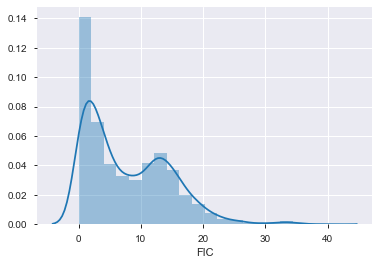

In [28]:
sns.distplot(data.FIC, bins=20)

### Transformar target

In [29]:
qt = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
normal_FIC = qt.fit_transform(data.FIC.to_numpy().reshape(-1,1))

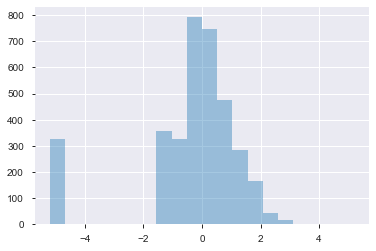

In [30]:
sns.distplot(normal_FIC, kde=False, bins=20)

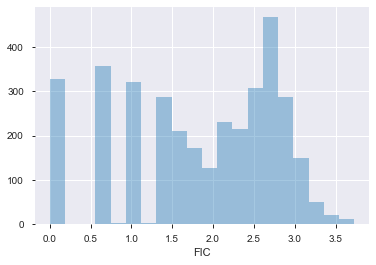

In [31]:
sns.distplot(np.log1p(data.FIC), kde=False, bins=20)

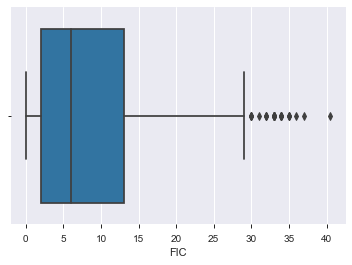

In [32]:
sns.boxplot(x=data['FIC'])

### Proceso de Outliers

In [33]:
data_dfo = data[np.abs(data.FIC-data.FIC.mean())<=(1.5*data.FIC.std())]

In [34]:
data_dfo.shape

(3306, 46)

In [35]:
data_dfo.sample(5)

,FAS_CON_P,FAS_CON_S,FAS_CON_T,TEN_LIN_SE,CAP_ELO,CAP_CHA,CONF,POSTO,POT_NOM,PER_FER,...,NEIG_DEGREE,BET_CEN,CLO_CEN,PAGE_RANK,DISTANCE_SUB,FCONV_R,I_NOM_MED_R,I_NOM_MIN_R,Z_ANG_SUB,FIC
COD_ID,,,,,,,,,,,,,,,,,,,,,
26877802,ABC,ABC,0,0.38,2H,12,RA,PT,45.00,0.47,...,2.00,0.00,0.03,0.00,1762.25,0.42,230.00,97.00,-32.08,4.00
52605794,ABC,ABC,0,0.38,2H,12,RA,PT,45.00,0.47,...,2.00,0.00,0.00,0.00,1723.68,0.36,495.00,130.00,-44.17,2.00
26880567,ABC,ABC,0,0.38,3H,12,RA,PT,75.00,0.43,...,2.00,0.00,0.01,0.00,8043.04,0.39,330.00,54.00,-34.97,3.00
26877638,ABC,ABC,0,0.38,3H,12,RA,PT,75.00,0.43,...,2.00,0.04,0.02,0.00,3187.16,0.43,365.00,54.00,-26.22,1.00
26876816,ABC,A,0,0.38,2H,12,RA,PT,45.00,0.47,...,2.00,0.01,0.00,0.00,13267.09,0.42,438.00,54.00,-22.72,8.00


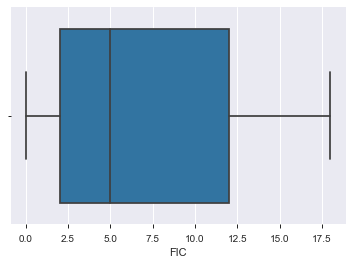

In [36]:
sns.boxplot(x=data_dfo['FIC'])

## Split Data

#### Vemos la frecuencia de ocurrencia de los valores de FIC

In [37]:
data_X, data_FIC, FIC_bin = prepare_data(data_dfo, categoricas)

In [38]:
data_X.shape

(3305, 218)

In [39]:
data_FIC.shape

(3305,)

In [40]:
df = pd.value_counts(np.array(data_FIC)).to_frame().reset_index()
df.rename(columns={"index":"FIC",0:"frecuencia"})

,FIC,frecuencia
0,1.00,356
1,0.00,328
2,2.00,322
3,3.00,286
4,4.00,208
5,13.00,178
6,5.00,168
7,12.00,161
8,14.00,159
9,16.00,133


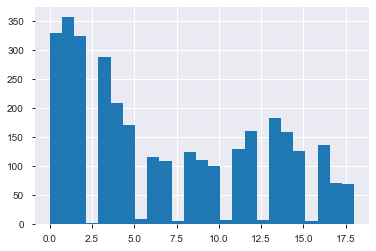

In [41]:
# Evaluamos la distribucion de la variable dependiente
hist, bin_edges = np.histogram(data_FIC, 25)
plt.hist(data_FIC, bins=bin_edges)
plt.show()

In [42]:
# Vemos la frecuencia de ocurrencia de los valores de FIC discretizado con 4 bins
df = pd.value_counts(np.array(FIC_bin)).to_frame().reset_index()
df.rename(columns={"index":"FIC",0:"frecuencia"})

,FIC,frecuencia
0,0,1510
1,1,639
2,2,589
3,3,567


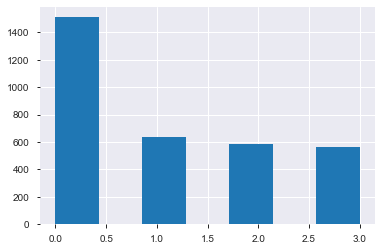

In [43]:
# Evaluamos la distribucion de la variable dependiente discretizada
hist, bin_edges = np.histogram(FIC_bin, 7)
plt.hist(FIC_bin, bins=bin_edges)
plt.show()

## Split and get baselines

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [46]:
#data_labeled = pd.get_dummies(data.dropna(), columns=categorical, dummy_na= True, drop_first= True)

In [47]:
#X_train, X_test, y_train, y_test = train_test_split(data_labeled.drop('FIC',axis=1), data_labeled.FIC, test_size=0.3, random_state=0)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_FIC, test_size=0.2, random_state=0)

In [49]:
xb_reg = XGBRegressor(learning_rate=0.03,
                         n_estimators=1000,
                         max_depth=3,
                         subsample=0.8,
                         colsample_bytree=1,
                         gamma=1,
                         objective='reg:squarederror',
                         n_jobs=-1,
                         eval_metric='mae')

# Entreno sobre el logarimo de la variable de salidad
xb_reg.fit(X_train, np.log1p(y_train))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=1,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [50]:
desc_importance = np.sort(xb_reg.feature_importances_)

In [51]:
ft_qty = (desc_importance[::-1] > 0).sum()

In [52]:
indices = np.argsort(xb_reg.feature_importances_)[::-1]
#top_features = data_X.columns[indices][:ft_qty]
top_features = data_X.columns[indices[0:20]]
top_features

Index(['DISTANCE_SUB', 'CTMT_PNTMT_STD', 'CLO_CEN', 'TIP_CC_RES-Tipo3',
       'POT_NOM', 'PERD_A4_B', 'I_NOM_MED_R', 'CTMT_ENE_STD', 'CTMT_PNTMT_MED',
       'UCBT_ENE_MED', 'I_NOM_MIN_R', 'CTMT_PNTBT_MAX', 'PAGE_RANK',
       'TIP_TRAFO_M', 'FAS_CON_S_ABCN', 'CTMT_ENE_MED', 'GRU_TAR_B3',
       'TIP_CC_RES-Tipo10', 'PERD_A4', 'TIP_CC_RES-Tipo5'],
      dtype='object')

In [53]:
data_top = data_X[top_features]
data_top.sample(5)

,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,UCBT_ENE_MED,I_NOM_MIN_R,CTMT_PNTBT_MAX,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5
COD_ID,,,,,,,,,,,,,,,,,,,,
26876488,19671.69,236.63,0.01,1,25.00,506374.22,438.00,49923.49,909.23,157.00,54.00,158336.61,0.00,1,0,844268.40,0,0,180278.34,0
26876462,19119.05,236.63,0.01,0,10.00,506374.22,438.00,49923.49,909.23,192.00,54.00,158336.61,0.00,0,0,844268.40,0,0,180278.34,0
26877055,30452.04,0.00,0.00,0,5.00,475052.12,230.00,21457.60,0.00,67.50,54.00,110460.45,0.00,1,0,459459.02,0,0,100388.53,0
26876583,26896.22,236.63,0.00,0,5.00,506374.22,438.00,49923.49,909.23,0.00,54.00,158336.61,0.00,1,0,844268.40,0,0,180278.34,0
26877196,35719.12,0.00,0.00,0,10.00,475052.12,171.00,21457.60,0.00,122.50,54.00,110460.45,0.00,1,0,459459.02,0,0,100388.53,0


### Se evalúa con Regresion Lineal las top features

In [54]:
data_top.shape

(3305, 20)

In [55]:
data_FIC.shape

(3305,)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data_top, data_FIC, test_size=0.2, random_state=0)

In [57]:
regressor = LinearRegression(n_jobs=-1)
regressor.fit(data_top, data_FIC)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [58]:
y_pred = regressor.predict(X_test)

#### Regresión por Cuadrados Mínimos Ordinarios

In [59]:
# Consideramos un nivel de significancia del 0.05 para evaluarlo contra el P-value 
# para saber que features vamos descartando

In [60]:
X = np.append(arr = np.ones((data_top.shape[0], 1)).astype(int), values = data_top, axis = 1)
SL = 0.05
X_opt = X[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]

In [61]:
X_Modeled = backwardElimination(X_opt, data_FIC, SL)
regressor_OLS = sm.OLS(endog = data_FIC, exog = X_Modeled).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FIC   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     386.9
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        08:32:28   Log-Likelihood:                -8599.6
No. Observations:                3305   AIC:                         1.723e+04
Df Residuals:                    3288   BIC:                         1.734e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6153      0.381     12.121      0.000       3.869       5.362
x1             0.0003   9.58e-06     31.175      0.000       0.000       0.000
x2             0.0001    1.4e-05      9.791      0.000       0.000       0.000
x3           -87.0829     15.971     -5.453      0.000    -118.396     -55.769
x4            -0.0074      0.001     -5.539      0.000      -0.010      -0.005
x5          1.656e-05   9.79e-07     16.913      0.000    1.46e-05    1.85e-05
x6            -0.0039      0.001     -5.837      0.000      -0.005      -0.003
x7         -8.727e-06   3.36e-06     -2.594      0.010   -1.53e-05   -2.13e-06
x8          6.031e-05   3.22e-06     18.702      0.000     5.4e-05    6.66e-05
x9            -0.0025      0.001     -2.074      0.038      -0.005      -0.000
x10        -5.871e-06   1.21e-06     -4.851      0.000   -8.24e-06    -3.5e-06
x11          233.9157     70.556      3.315      0.001      95.578     372.253
x12            1.0985      0.185      5.950      0.000       0.737       1.461
x13        -4.062e-06   4.38e-07     -9.265      0.000   -4.92e-06    -3.2e-06
x14           -1.2409      0.242     -5.131      0.000      -1.715      -0.767
x15           -0.6179      0.259     -2.381      0.017      -1.127      -0.109
x16        -4.316e-06   8.96e-07     -4.818      0.000   -6.07e-06   -2.56e-06
==============================================================================
Omnibus:                      156.037   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.391
Skew:                           0.407   Prob(JB):                     3.14e-54
Kurtosis:                       4.062   Cond. No.                     1.55e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
X_Modeled = backwardEliminationRQ(X_opt, data_FIC, SL)
regressor_OLS = sm.OLS(endog = data_FIC, exog = X_Modeled).fit()
regressor_OLS.summary()


                            OLS Regression Results                            
Dep. Variable:                    FIC   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     344.6
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        08:32:28   Log-Likelihood:                -8596.8
No. Observations:                3305   AIC:                         1.723e+04
Df Residuals:                    3286   BIC:                         1.735e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6111      0.381     12.117      0.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FIC   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     360.0
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        08:32:28   Log-Likelihood:                -8611.4
No. Observations:                3305   AIC:                         1.726e+04
Df Residuals:                    3287   BIC:                         1.737e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7639      0.381     12.499      0.000       4.017       5.511
x1             0.0003   1.01e-05     30.198      0.000       0.000       0.000
x2             0.0001   1.41e-05      9.623      0.000       0.000       0.000
x3           -85.1174     16.039     -5.307      0.000    -116.564     -53.671
x4            -0.0073      0.001     -5.258      0.000      -0.010      -0.005
x5          1.681e-05   9.87e-07     17.035      0.000    1.49e-05    1.87e-05
x6            -0.0040      0.001     -5.958      0.000      -0.005      -0.003
x7         -8.014e-06   3.38e-06     -2.368      0.018   -1.47e-05   -1.38e-06
x8          6.127e-05   3.24e-06     18.922      0.000    5.49e-05    6.76e-05
x9         -6.746e-06   2.88e-06     -2.340      0.019   -1.24e-05   -1.09e-06
x10           -0.0021      0.001     -1.785      0.074      -0.004       0.000
x11        -6.359e-06   1.22e-06     -5.211      0.000   -8.75e-06   -3.97e-06
x12          230.4752     70.845      3.253      0.001      91.571     369.379
x13        -4.179e-06   4.39e-07     -9.511      0.000   -5.04e-06   -3.32e-06
x14           -0.7926      0.229     -3.454      0.001      -1.243      -0.343
x15           -0.5716      0.261     -2.190      0.029      -1.083      -0.060
x16        -4.203e-06   9.03e-07     -4.655      0.000   -5.97e-06   -2.43e-06
x17                 0          0        nan        nan           0           0
x18           -0.4379      0.170     -2.572      0.010      -0.772      -0.104
==============================================================================
Omnibus:                      163.699   Durbin-Watson:                   1.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.561
Skew:                           0.421   Prob(JB):                     4.33e-57
Kurtosis:                       4.084   Cond. No.                     1.86e+28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.45e-41. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Evaluación de correlacion y sesgo de dataset procesado mediante el perfilador de pandas

In [63]:
#data_top.index
data_dfo.reset_index(inplace=True)
data_top.reset_index(inplace=True)


In [64]:
df_FIC  = data_dfo.FIC
data_top_full = pd.concat((data_top, df_FIC), axis=1)

In [65]:
data_top_full

,COD_ID,DISTANCE_SUB,CTMT_PNTMT_STD,CLO_CEN,TIP_CC_RES-Tipo3,POT_NOM,PERD_A4_B,I_NOM_MED_R,CTMT_ENE_STD,CTMT_PNTMT_MED,...,CTMT_PNTBT_MAX,PAGE_RANK,TIP_TRAFO_M,FAS_CON_S_ABCN,CTMT_ENE_MED,GRU_TAR_B3,TIP_CC_RES-Tipo10,PERD_A4,TIP_CC_RES-Tipo5,FIC
0,26879192,5104.49,2088.58,0.02,0.00,45.00,389840.98,365.00,43960.32,18885.60,...,143337.13,0.00,0.00,0.00,1421387.50,0.00,0.00,255476.21,0.00,1.00
1,26880293,3774.91,8194.44,0.01,0.00,112.50,408741.02,438.00,67863.54,22266.87,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0.00
2,26880293,3774.91,8194.44,0.03,0.00,112.50,408741.02,438.00,67863.54,22266.87,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0.00
3,26880295,3897.62,8194.44,0.01,0.00,75.00,408741.02,438.00,67863.54,22266.87,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0.00
4,26880295,3897.62,8194.44,0.03,0.00,75.00,408741.02,438.00,67863.54,22266.87,...,119688.30,0.00,0.00,0.00,1648865.40,0.00,0.00,350609.30,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,26878634,15732.31,4838.27,0.00,0.00,15.00,379666.04,168.00,93329.28,13712.42,...,320696.78,0.00,0.00,0.00,1013653.45,0.00,0.00,198609.64,0.00,16.00
3302,26878635,16620.79,4838.27,0.00,0.00,10.00,379666.04,168.00,93329.28,13712.42,...,320696.78,0.00,1.00,0.00,1013653.45,0.00,0.00,198609.64,0.00,8.00
3303,26878636,16872.15,4838.27,0.00,0.00,45.00,379666.04,168.00,93329.28,13712.42,...,320696.78,0.00,0.00,1.00,1013653.45,0.00,0.00,198609.64,0.00,8.00
3304,26878637,17049.51,4838.27,0.00,0.00,15.00,379666.04,168.00,93329.28,13712.42,...,320696.78,0.00,0.00,1.00,1013653.45,0.00,0.00,198609.64,0.00,13.00


In [66]:
#pp.ProfileReport(data_top_full)

#### Verificación de consistencia de datos previa a la grabación

In [67]:
df = data_top_full
df.shape

(3306, 22)

In [68]:
df.dtypes

COD_ID                object
DISTANCE_SUB         float64
CTMT_PNTMT_STD       float64
CLO_CEN              float64
TIP_CC_RES-Tipo3     float64
POT_NOM              float64
PERD_A4_B            float64
I_NOM_MED_R          float64
CTMT_ENE_STD         float64
CTMT_PNTMT_MED       float64
UCBT_ENE_MED         float64
I_NOM_MIN_R          float64
CTMT_PNTBT_MAX       float64
PAGE_RANK            float64
TIP_TRAFO_M          float64
FAS_CON_S_ABCN       float64
CTMT_ENE_MED         float64
GRU_TAR_B3           float64
TIP_CC_RES-Tipo10    float64
PERD_A4              float64
TIP_CC_RES-Tipo5     float64
FIC                  float64
dtype: object

In [69]:
 df.shape

(3306, 22)

In [70]:
if  (df[df.isnull().any(1)]).empty:
    print ('no hay nulos')
else:
    df.drop(df[df.isnull().any(1)].index, inplace = True)
    df.shape

In [71]:
df.shape

(3305, 22)

#### Grabacion de archivo UNTRD para analisis de calidad del servicio

In [72]:
data_path = BASE_DIR+'UNTRD_ENF.csv'

In [73]:
df.to_csv(data_path, index=False)